NAME : K.HARI TEJA

BATCH-ID : 2216965

PROJECT : PUBG FINAL PREDICTION PROJECT

BATCH : PYFSDDS-COHORT3

MAIL-ID : haritejakoppula@gmail.com

# PUBG FINAL PLACEMENT PREDICTION

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import gc, sys
import warnings
warnings.filterwarnings("ignore")

# Auxiliary Functions

In [2]:
def reduceMemory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage. 
        # Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage       
    """
    import numpy as np

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

In [3]:
def visualize(col_name, num_bin=10):
    '''
    Function for visualization
    '''
    title_name = col_name[0].upper() + col_name[1:]
    f, ax = plt.subplots()
    plt.xlabel(title_name)
    plt.ylabel('log Count')
    ax.set_yscale('log')
    df_train.hist(column=col_name,ax=ax,bins=num_bin)
    plt.title('Histogram of ' + title_name)
    tmp = df_train[col_name].value_counts().sort_values(ascending=False)

    print('Min value of ' + title_name + ' is: ',min(tmp.index))
    print('Max value of ' + title_name + ' is: ',max(tmp.index))

In [4]:
def BuildFeature(is_train=True):
    '''
    Function for feature engineering
    is_train incicates whether the train set or the test set is processed
    '''
    y = None
    test_idx = None
    
    if is_train: 
        print("Reading train.csv")
        df = pd.read_csv('pubg_train.csv')           
        df = df[df['maxPlace'] > 1]
    else:
        print("Reading test.csv")
        df = pd.read_csv('pubg_test.csv')
        test_idx = df.Id
    
    # Reduce the memory usage
    df = reduce_mem_usage(df)
    
    print("Delete Unuseful Columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")  
    
    if is_train: 
        print("Read Labels")
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("Read Group mean features")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    if is_train:
        df_out = agg.reset_index()[['matchId','groupId']]
    else:
        df_out = df[['matchId','groupId']]
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])

    print("Read Group max features")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("Read Group min features")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("Read Group size features")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("Read Match mean features")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    print("Read Match size features")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)
    X = df_out
    feature_names = list(df_out.columns)
    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y, feature_names, test_idx


# Preprocessing Data

In [5]:
develop_mode = False
if develop_mode:
    df_train = reduceMemory(pd.read_csv('pubg_train.csv', nrows=5000))
    df_test = reduceMemory(pd.read_csv('pubg_test.csv'))
else:
    df_train = reduceMemory(pd.read_csv('pubg_train.csv'))
    df_test = reduceMemory(pd.read_csv('pubg_test.csv'))

In [6]:
print('The sizes of the datasets are:')
print('Training Dataset: ', df_train.shape)
print('Testing Dataset: ', df_test.shape)

The sizes of the datasets are:
Training Dataset:  (4446966, 29)
Testing Dataset:  (1934174, 28)


In [7]:
# Get Sample Data
df_train.head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.7500,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.500000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.906250,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.7500,2,0,0.187500
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000000,1,1,0,44,...,0,0.000000,0,0.000000,0,0,34.6875,1,0,0.036987
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000000,0,0,0,96,...,0,0.000000,0,0.000000,0,0,13.5000,1,1497,0.000000
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.539062,0,0,0,48,...,0,2004.000000,0,0.000000,0,0,1089.0000,6,1500,0.736816
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.593750,0,0,0,64,...,0,0.000000,0,0.000000,0,0,800.0000,4,0,0.370361
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.281250,0,0,0,74,...,0,0.000000,0,0.000000,0,0,65.6875,1,0,0.214355


In [8]:
group_tmp = df_train[df_train['matchId']=='df014fbee741c6']['groupId'].value_counts().sort_values(ascending=False)

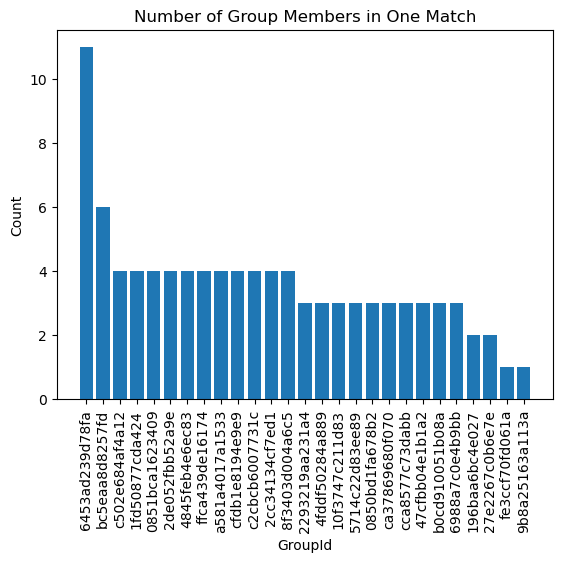

Min number of group members is:  1
Max number of group members is:  11


In [9]:
plt.figure()
plt.bar(group_tmp.index,group_tmp.values)
plt.xlabel('GroupId')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Number of Group Members in One Match')
plt.show()

print('Min number of group members is: ',min(group_tmp.values))
print('Max number of group members is: ',max(group_tmp.values))

# Assists Analysis

Min value of Assists is:  0
Max value of Assists is:  22


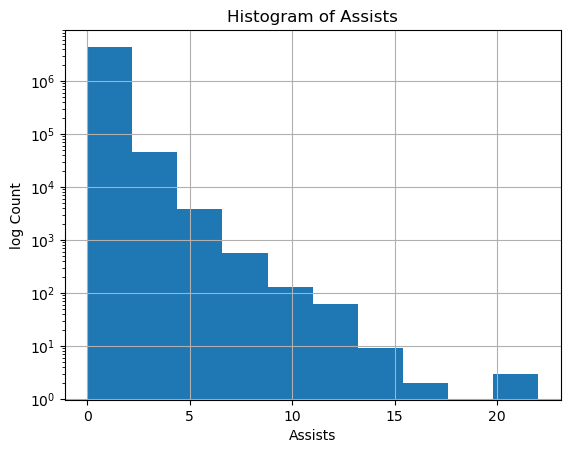

In [10]:
visualize('assists')

# RoadKills Analysis

Min value of RoadKills is:  0
Max value of RoadKills is:  18


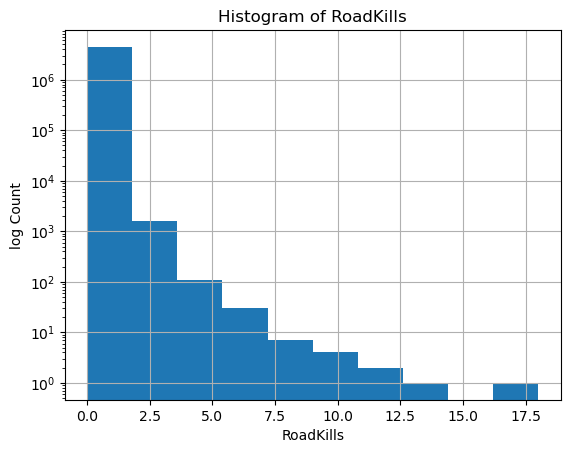

In [11]:
visualize('roadKills')

# KillStreaks Analysis

Min value of KillStreaks is:  0
Max value of KillStreaks is:  20


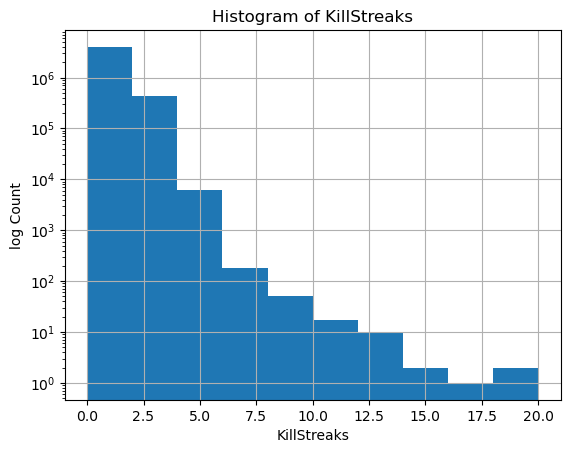

In [12]:
visualize('killStreaks')

Min value of TeamKills is:  0
Max value of TeamKills is:  12


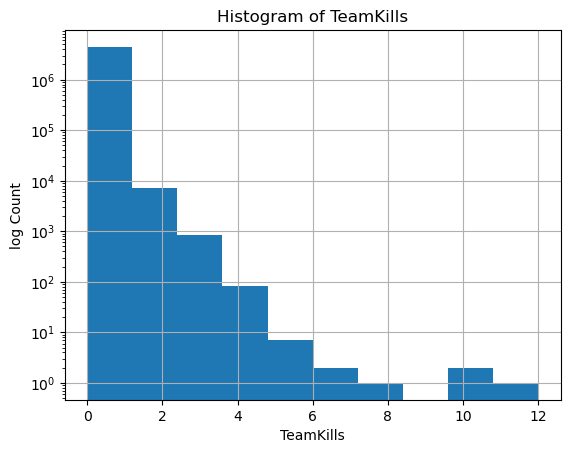

In [13]:
visualize('teamKills')

Min value of LongestKill is:  0.0
Max value of LongestKill is:  1094.0


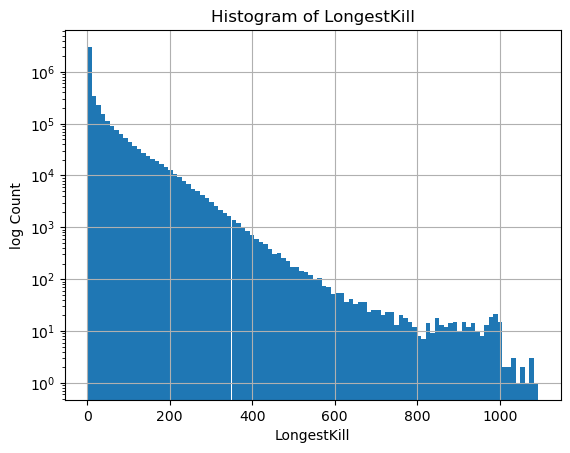

In [14]:
visualize('longestKill',num_bin=100)

Min value of WeaponsAcquired is:  0
Max value of WeaponsAcquired is:  236


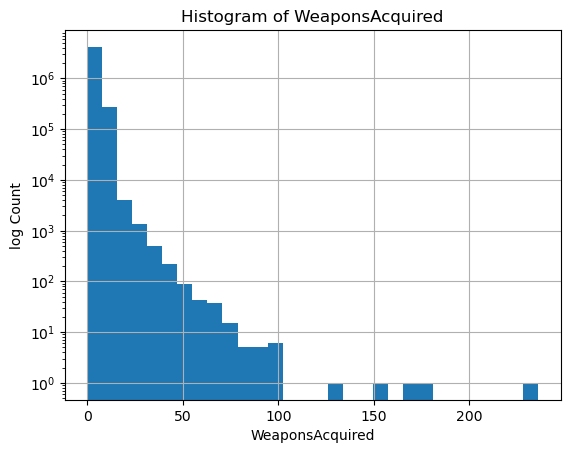

In [15]:
visualize('weaponsAcquired',num_bin=30)

Min value of HeadshotKills is:  0
Max value of HeadshotKills is:  64


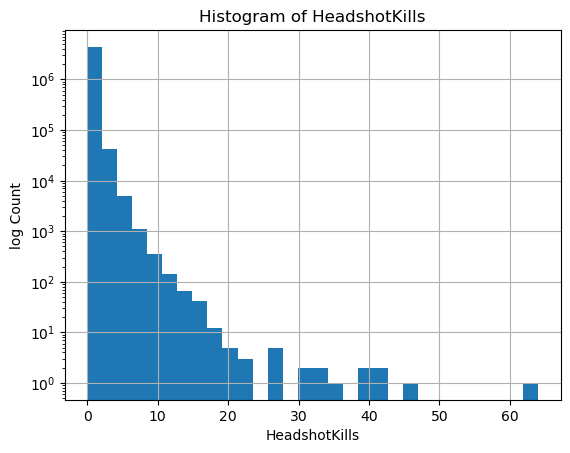

In [16]:
visualize('headshotKills',num_bin=30)

Min value of DBNOs is:  0
Max value of DBNOs is:  53


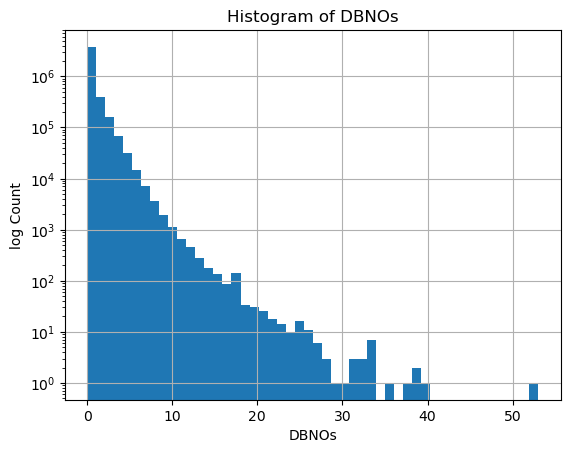

In [17]:
visualize('DBNOs',num_bin=50)

Min value of Boosts is:  0
Max value of Boosts is:  33


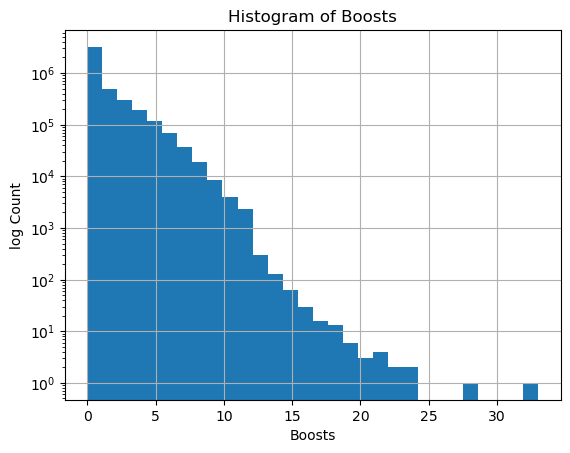

In [18]:
visualize('boosts',num_bin=30)

Min value of Heals is:  0
Max value of Heals is:  80


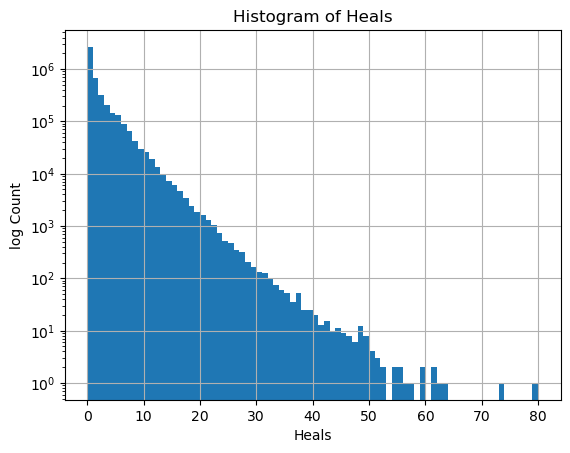

In [19]:
visualize('heals',num_bin=80)

Min value of DamageDealt is:  0.0
Max value of DamageDealt is:  6616.0


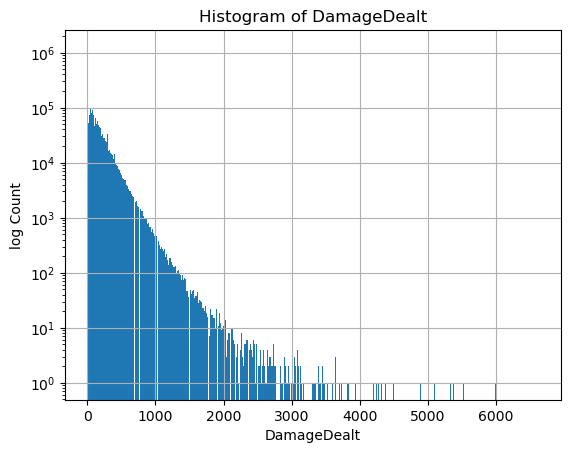

In [20]:
visualize('damageDealt',num_bin=1000)

Min value of Revives is:  0
Max value of Revives is:  39


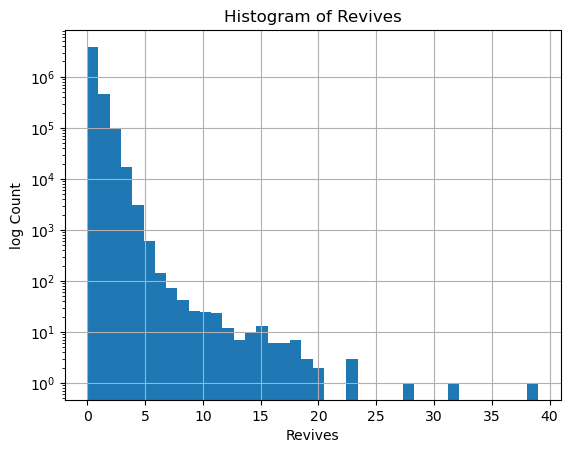

In [21]:
visualize('revives',num_bin=40)

Min value of WalkDistance is:  0.0
Max value of WalkDistance is:  25776.0


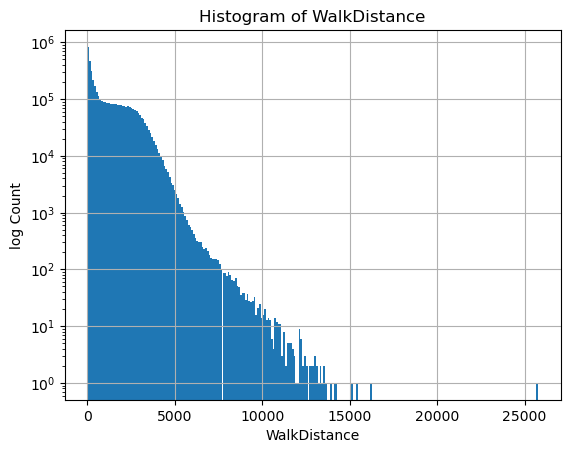

In [22]:
visualize('walkDistance',num_bin=260)

Min value of RideDistance is:  0.0
Max value of RideDistance is:  40704.0


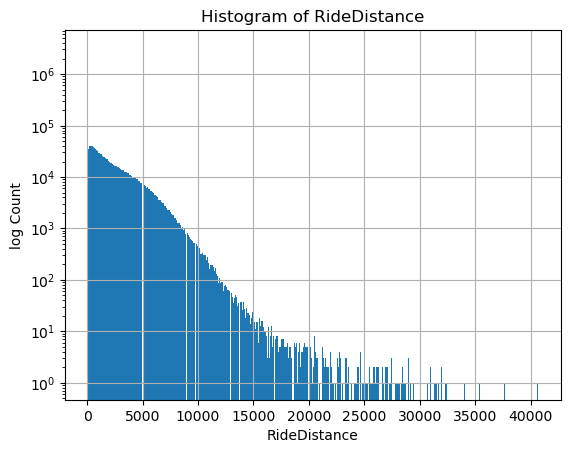

In [23]:
visualize('rideDistance',num_bin=400)

Min value of SwimDistance is:  0.0
Max value of SwimDistance is:  3824.0


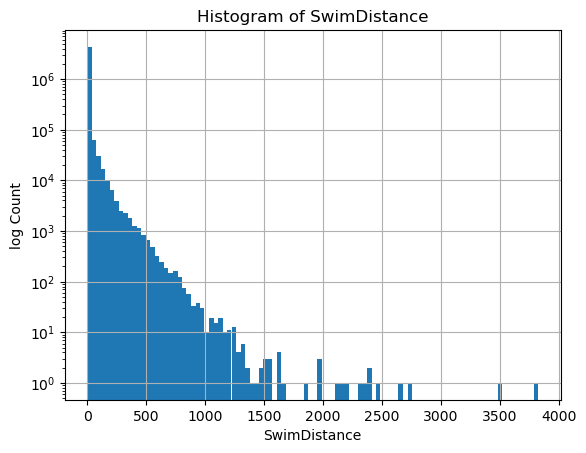

In [24]:
visualize('swimDistance',num_bin=100)

Min value of VehicleDestroys is:  0
Max value of VehicleDestroys is:  5


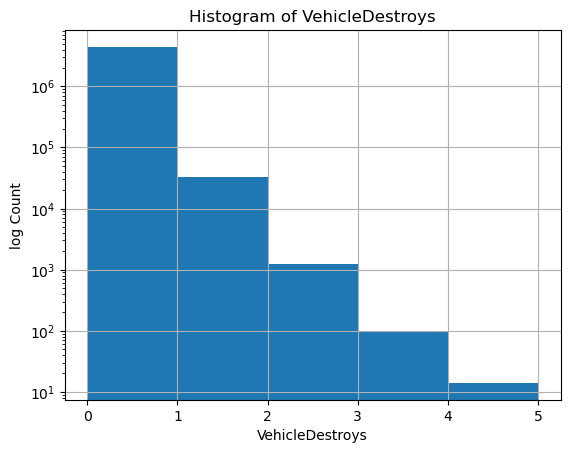

In [25]:
visualize('vehicleDestroys',num_bin=5)

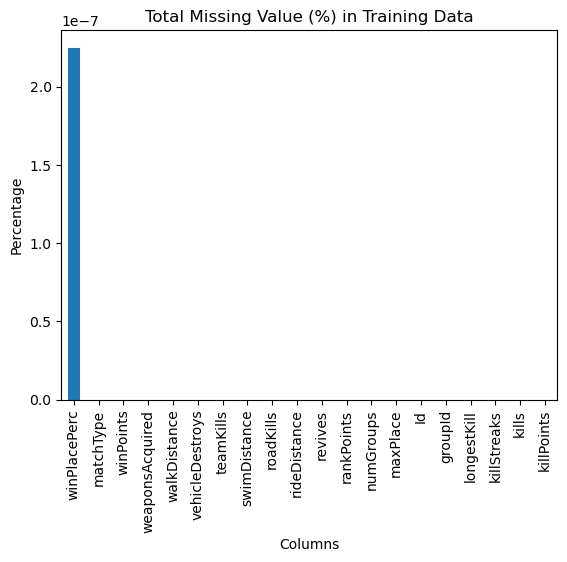

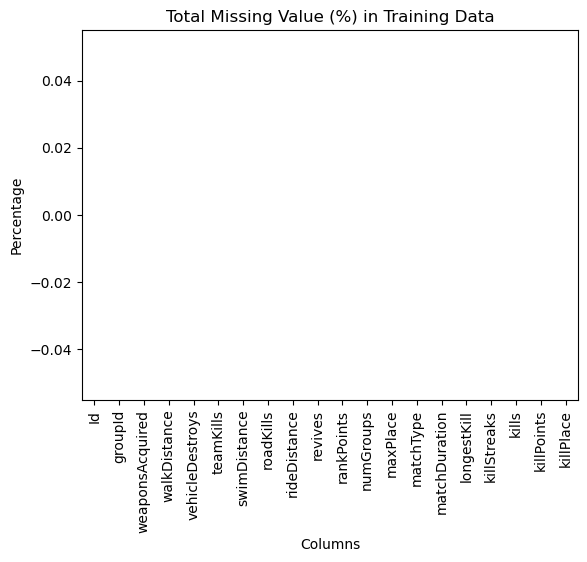

In [26]:
def MissValueAnalysis():
    miss_total = df_train.isnull().sum().sort_values(ascending=False)
    miss_percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([miss_total, miss_percent], axis=1, keys=['total', 'percent'])

    percent_data = miss_percent.head(20)
    percent_data.plot(kind="bar")
    plt.xlabel("Columns")
    plt.ylabel("Percentage")
    plt.title("Total Missing Value (%) in Training Data")
    plt.show()

    miss_total = df_test.isnull().sum().sort_values(ascending=False)
    miss_percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([miss_total, miss_percent], axis=1, keys=['total', 'percent'])

    percent_data = miss_percent.head(20)
    percent_data.plot(kind="bar")
    plt.xlabel("Columns")
    plt.ylabel("Percentage")
    plt.title("Total Missing Value (%) in Training Data")
    plt.show()

MissValueAnalysis()

# Correlation Analysis

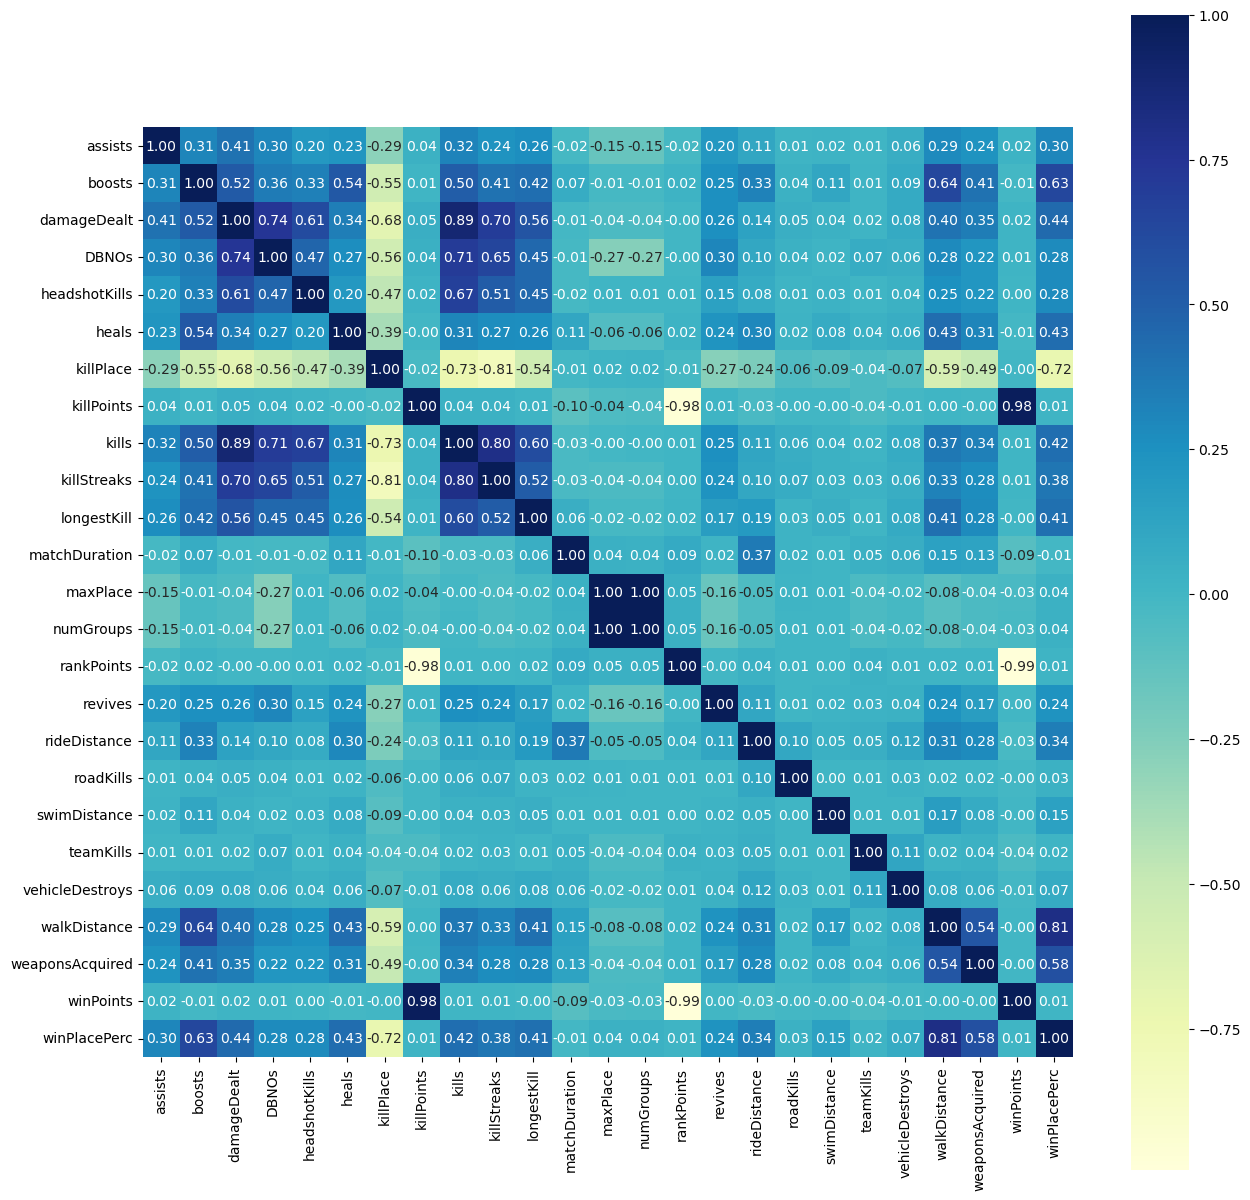

In [27]:
def CorrelationAnalysis():
    corr = df_train.corr()
    f, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(corr,cbar=True, annot=True, 
                          square=True, fmt='.2f', 
                          cmap='YlGnBu')

CorrelationAnalysis()

# walkDistance vs winPlacePerc

<AxesSubplot:title={'center':'longestKill vs winPlacePerc'}, xlabel='longestKill', ylabel='winPlacePerc'>

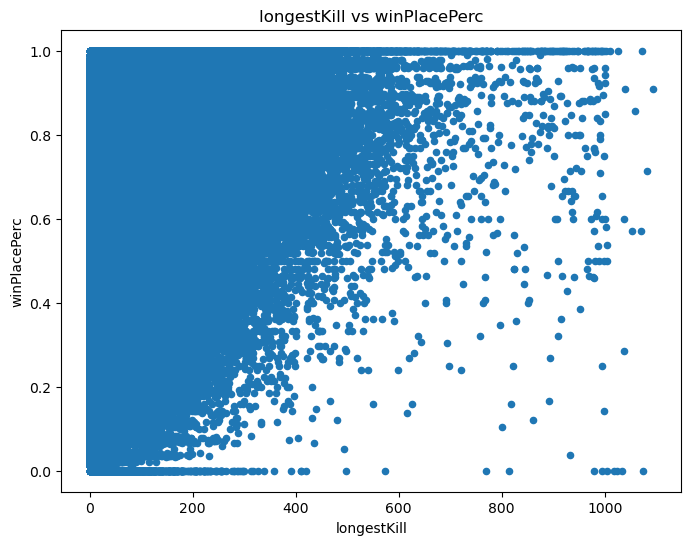

In [28]:
df_train.plot(x="longestKill",y="winPlacePerc", kind="scatter", figsize = (8,6), title='longestKill vs winPlacePerc')

# heals vs winPlacePerc

<AxesSubplot:title={'center':'heals vs winPlacePerc'}, xlabel='heals', ylabel='winPlacePerc'>

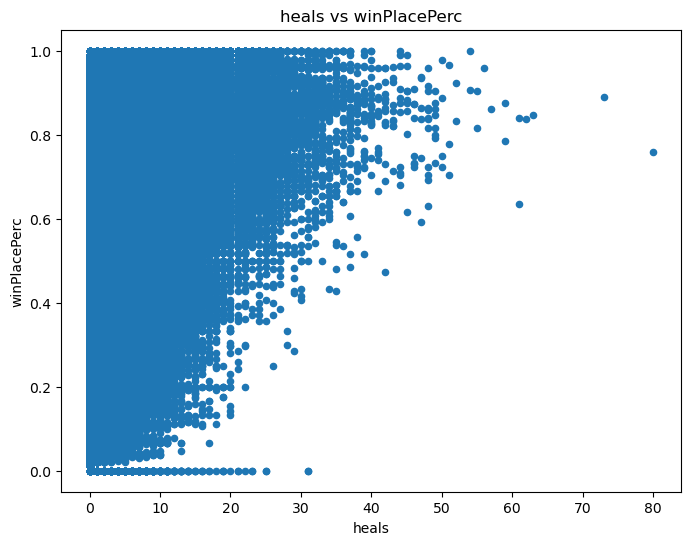

In [29]:
df_train.plot(x="heals",y="winPlacePerc", kind="scatter", figsize=(8,6), title='heals vs winPlacePerc')

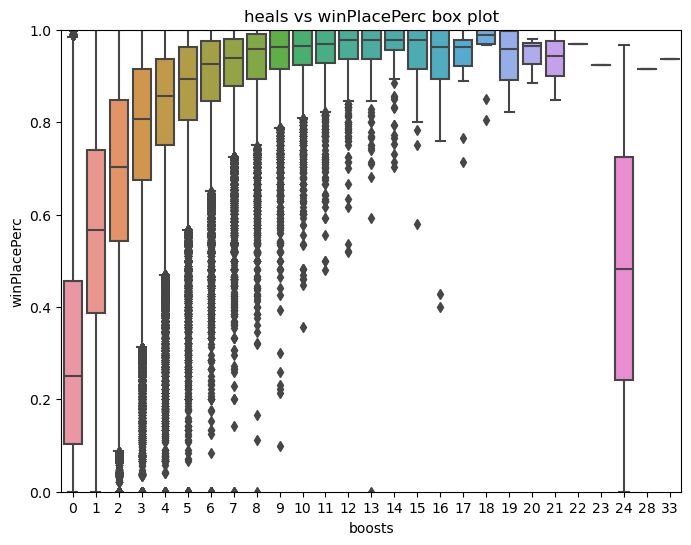

In [30]:
def HealsVSwinPlacePerc():
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sns.boxplot(x='boosts', y="winPlacePerc", data=df_train)
    plt.title('heals vs winPlacePerc box plot')
    fig.axis(ymin=0, ymax=1)

HealsVSwinPlacePerc()

# longestKill vs winPlacePerc

<AxesSubplot:title={'center':'longestKill vs winPlacePerc'}, xlabel='longestKill', ylabel='winPlacePerc'>

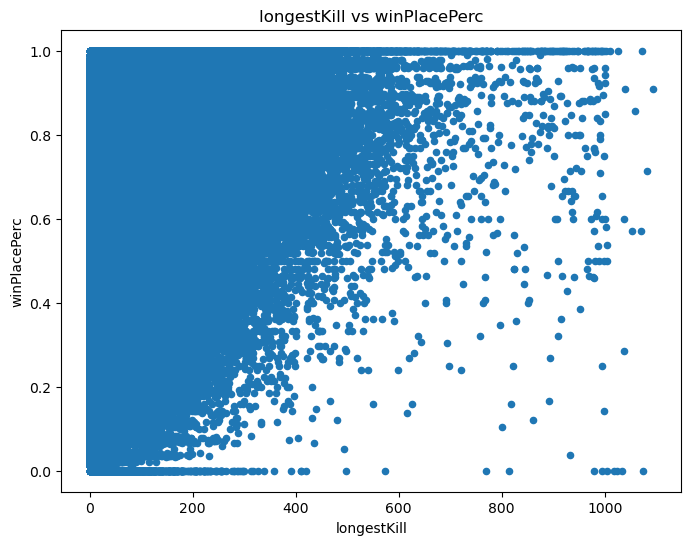

In [31]:
df_train.plot(x="longestKill",y="winPlacePerc", kind="scatter", figsize = (8,6), title='longestKill vs winPlacePerc')

# Feature Engineering

In [33]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [35]:
X_train, y_train, train_columns, _ = BuildFeature(is_train=True)
X_test, _, _ , test_idx = BuildFeature(is_train=False)

Reading train.csv
Memory usage of dataframe is 1017.83 MB --> 373.20 MB (Decreased by 63.3%)
Delete Unuseful Columns
Read Labels
Read Group mean features
Read Group max features
Read Group min features
Read Group size features
Read Match mean features
Read Match size features
Reading test.csv
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
Delete Unuseful Columns
Read Group mean features
Read Group max features
Read Group min features
Read Group size features
Read Match mean features
Read Match size features


In [36]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 1994.71 MB --> 1117.19 MB (Decreased by 44.0%)
Memory usage of dataframe is 1903.60 MB --> 1064.32 MB (Decreased by 44.1%)


# Model

# Linear Regression

In [37]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression(n_jobs=4, normalize=True)
LR_model.fit(X_train,y_train)

LinearRegression(n_jobs=4, normalize=True)

In [38]:
LR_model.score(X_train,y_train)

0.9492039011534797

In [39]:
y_pred_train = LR_model.predict(X_train)
y_pred_test = LR_model.predict(X_test)

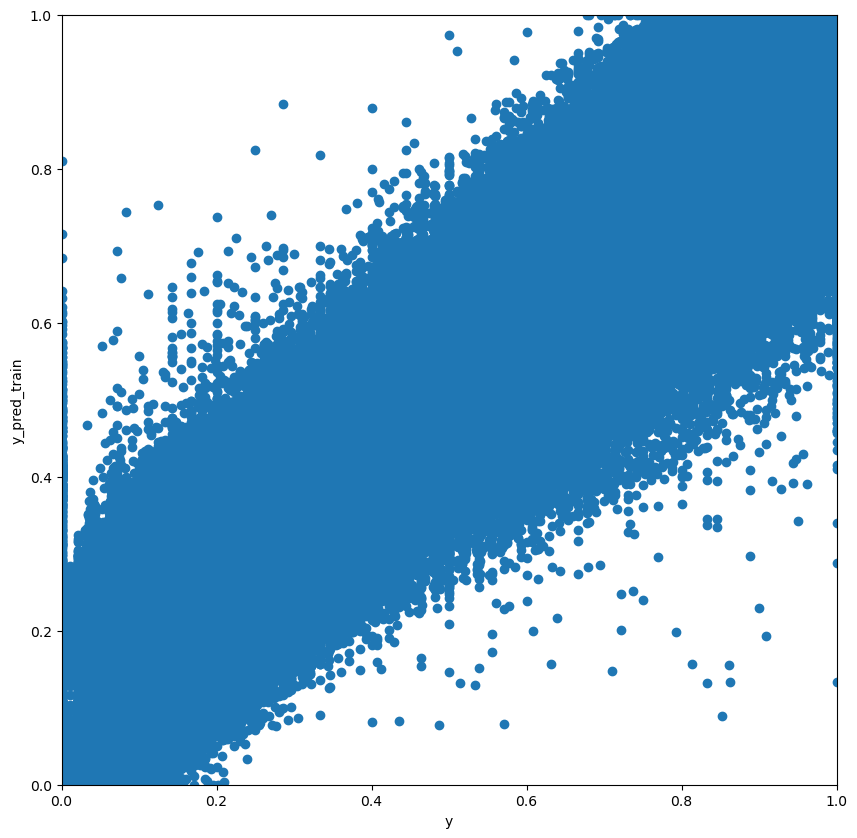

In [40]:
y_pred_train[y_pred_train>1] = 1
y_pred_train[y_pred_train<0] = 0

f, ax = plt.subplots(figsize=(10,10))
plt.scatter(y_train, y_pred_train)
plt.xlabel("y")
plt.ylabel("y_pred_train")
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Submit prediction for testing data

In [41]:
df_test['winPlacePerc'] = y_pred_test
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission_lr.csv', index=False)

# Neural Network

In [50]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(hidden_layer_sizes=(300, 200, 100, 50, ), activation='relu', 
                   solver='adam', alpha=0.0001, batch_size=128,  learning_rate='constant', 
                   learning_rate_init=0.001, max_iter=2, shuffle=True, verbose=True, 
                   early_stopping=True, validation_fraction=0.2)
clf.fit(X_train, y_train) 

Iteration 1, loss = 4.58759965
Validation score: 0.880061
Iteration 2, loss = 0.13196285
Validation score: 0.872558


MLPRegressor(batch_size=128, early_stopping=True,
             hidden_layer_sizes=(300, 200, 100, 50), max_iter=2,
             validation_fraction=0.2, verbose=True)

In [51]:
yPred = clf.predict(X_train)
yPred[yPred > 1] = 1
yPred[yPred < 0] = 0

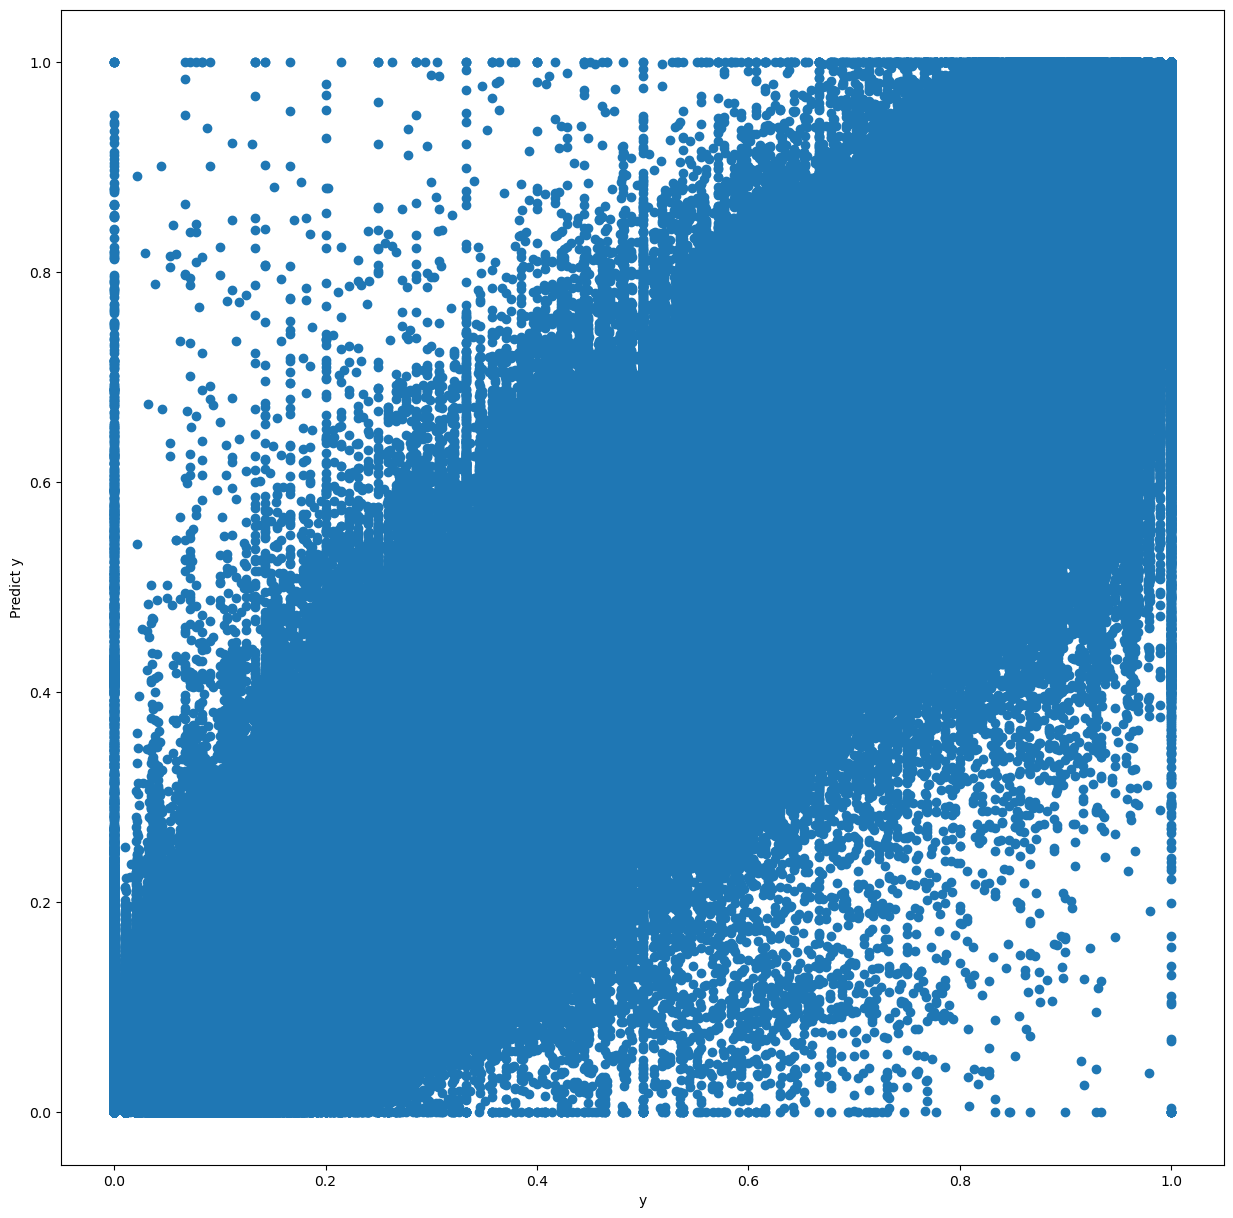

In [52]:
plt.figure(figsize=(15, 15))
plt.scatter(y_train, yPred)
plt.xlabel("y")
plt.ylabel("Predict y")
plt.show()

# Submit prediction for testing data

In [54]:
Xtrain = None
ytrain = None
yPred = clf.predict(X_test)
yPred[yPred > 1] = 1
yPred[yPred < 0] = 0
df_test['winPlacePerc'] = yPred
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission.csv', index=False)

# Gradient Boost Regression Tree

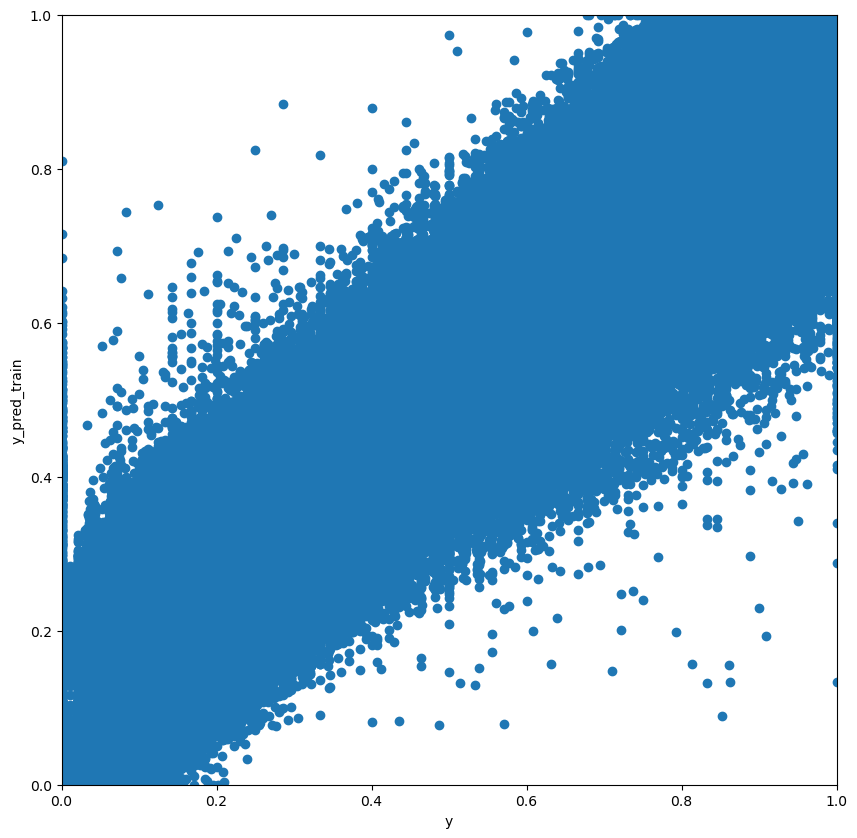

In [59]:
y_pred_train[y_pred_train>1] = 1
y_pred_train[y_pred_train<0] = 0

f, ax = plt.subplots(figsize=(10,10))
plt.scatter(y_train, y_pred_train)
plt.xlabel("y")
plt.ylabel("y_pred_train")
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [60]:
df_test['winPlacePerc'] = y_pred_test
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission_gbr.csv', index=False)

# Light GBM

In [64]:
df_test = reduceMemory(pd.read_csv('pubg_test.csv'))
df_test['winPlacePerc'] = yPred
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission.csv', index=False)

# Conclusion